In [1]:
print('__________________________')
print('')
print("Initialize Spectra Spectre")
print('__________________________')
import os
import sys
import json
import time
import massql
from massql import msql_fileloading, msql_engine
import pandas as pd
from tqdm import tqdm
from pyteomics import mzxml, mzml
import numpy as np
import fnmatch
import glob
from scipy.integrate import trapz
import warnings
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.simplefilter(action='ignore', category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

# pyinstaller command
# pyinstaller --noconfirm -F --console --collect-all "massql" --collect-all "matchms" --collect-all "pyarrow" --collect-all "pymzml"  "<absolute_path_to_script>"

__________________________

Initialize Spectra Spectre
__________________________


In [ ]:
"""Do not run in Jupyter"""
# if getattr(sys, 'frozen', False):
#     bundle_dir = sys._MEIPASS
# else:
#     bundle_dir = os.path.dirname(os.path.abspath(__file__))

# if getattr(sys, 'frozen', False) and hasattr(sys, '_MEIPASS'):
#     print('Running in a PyInstaller bundle')
# else:
#     print('Running in a normal Python process')
# print('')
# print( 'bundle dir is', bundle_dir )
# print( 'sys.argv[0] is', sys.argv[0] )
# print( 'sys.executable is', sys.executable )
# print( 'os.getcwd is', os.getcwd() )
# print('__________________________')

In [2]:
"""Configure"""
try:
    with open("spectre_config.json") as config_file:
      config = json.load(config_file)
      cache_setting = config['cache']
      print("Use Cache: "+str(cache_setting))
      queryfile = config['queryfile']
      datasaver = config['datasaver']
      print("Use Datasaver: "+str(datasaver))
      data_directory = config['data_directory']
except FileNotFoundError as e:
    print(f"FileNotFoundError\n"
          f"{e} \n"
          f"Not found in "+os.getcwd()+"\n")
    input("Press enter to exit...")
    exit()

Use Cache: True
Use Datasaver: True


In [3]:
"""Definition Used to Generate a Query"""
def create_query(name, KEGG, MS1_MZ, MS1_MZ_tolerance_ppm, retention_range, integration_range=None):
    query = "QUERY scaninfo(MS1DATA) FILTER MS1MZ="+     str(MS1_MZ)+":TOLERANCEPPM="+     str(MS1_MZ_tolerance_ppm)+     " AND RTMIN="+(str(retention_range[0]))+     " AND RTMAX="+str(retention_range[1])
    if integration_range is None:
        integration_range = retention_range
    return {'name':name, 'KEGG': KEGG, 'query':query, 'retention_range': retention_range, 'integration_range': integration_range}



In [4]:
"""Create Queries from Query File"""
try: 
    MassQL_query_df = pd.read_excel(queryfile)
    print("\nLoaded MassQL queries from: "+str(queryfile))
    queries = []
    for index, row in MassQL_query_df.iterrows():
        if row['ion_mode'] == 1:
            MS1MZ = row['M+H']
        else:
            MS1MZ = row['M-H']
        if row['INTEGRATION_MIN'] != 'Null':
            queries.append(create_query(row['Name'], row['KEGG'], MS1MZ, row['TOLERANCEPPM'], (row['RTMIN'], row['RTMAX']), (row['INTEGRATION_MIN'], row['INTEGRATION_MAX'])))
        else:
            queries.append(create_query(row['Name'], row['KEGG'], MS1MZ, row['TOLERANCEPPM'], (row['RTMIN'], row['RTMAX'])))
except FileNotFoundError as e:
    print(f"FileNotFoundError\n"
          f"{e} \n"
          f"Not found in "+os.getcwd()+"\n")
    input("Press enter to exit...")
    exit()


Loaded MassQL queries from: MassQL_Queries_system.xlsx


In [5]:
"""Override MassQL definition to add datasaver function"""
def custom_load_data_mzML_pyteomics(input_filename, datasaver=datasaver):
    """
    This is a loading operation using pyteomics to help with loading mzML files with ion mobility
    Args:
        input_filename ([type]): [description]
    """

    previous_ms1_scan = 0

    # MS1
    all_mz = []
    all_rt = []
    all_polarity = []
    all_i = []
    all_i_norm = []
    all_i_tic_norm = []
    all_scan = []

    # MS2
    all_msn_mz = []
    all_msn_rt = []
    all_msn_polarity = []
    all_msn_i = []
    all_msn_i_norm = []
    all_msn_i_tic_norm = []
    all_msn_scan = []
    all_msn_precmz = []
    all_msn_ms1scan = []
    all_msn_charge = []
    all_msn_mobility = []

    with mzml.read(input_filename) as reader:
        for spectrum in tqdm(reader):

            if len(spectrum["intensity array"]) == 0:
                continue
            
            # Getting the RT
            try:
                rt = spectrum["scanList"]["scan"][0]["scan start time"]
            except:
                rt = 0
            
            # Correcting the unit
            try:
                if spectrum["scanList"]["scan"][0]["scan start time"].unit_info == "second":
                    rt = rt / 60
            except:
                pass

            scan = int(spectrum["id"].replace("scanId=", "").split("scan=")[-1])
            
            if not "m/z array" in spectrum:
                # This is not a mass spectrum
                continue

            mzi_np = np.column_stack((spectrum["m/z array"], spectrum["intensity array"]))
            if datasaver:
                # if np.any(mzi_np > 0, axis=1):
                mzi_np = np.delete(mzi_np, np.where(mzi_np[:, 1] == 0), axis=0)

            mz, intensity = mzi_np.T
            i_max = max(intensity)
            i_sum = sum(intensity)

            # If there is no ms level, its likely an UV/VIS spectrum and we can skip
            if not "ms level" in spectrum:
                continue
            
            mslevel = spectrum["ms level"]
            if mslevel == 1:
                all_mz += list(mz)
                all_i += list(intensity)
                all_i_norm += list(intensity / i_max)
                all_i_tic_norm += list(intensity / i_sum)
                all_rt += len(mz) * [rt]
                all_scan += len(mz) * [scan]
                all_polarity += len(mz) * [msql_fileloading._determine_scan_polarity_pyteomics_mzML(spectrum)]

                previous_ms1_scan = scan

            if mslevel == 2:
                msn_mz = spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]["selected ion m/z"]
                msn_charge = 0

                if "charge state" in spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]:
                    msn_charge = int(spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]["charge state"])

                all_msn_mz += list(mz)
                all_msn_i += list(intensity)
                all_msn_i_norm += list(intensity / i_max)
                all_msn_i_tic_norm += list(intensity / i_sum)
                all_msn_rt += len(mz) * [rt]
                all_msn_scan += len(mz) * [scan]
                all_msn_polarity += len(mz) * [msql_fileloading._determine_scan_polarity_pyteomics_mzML(spectrum)]
                all_msn_precmz += len(mz) * [msn_mz]
                all_msn_ms1scan += len(mz) * [previous_ms1_scan] 
                all_msn_charge += len(mz) * [msn_charge]

                if "product ion mobility" in spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]:
                    mobility = spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]["product ion mobility"]
                    all_msn_mobility += len(mz) * [mobility]

    ms1_df = pd.DataFrame()
    if len(all_mz) > 0:
        ms1_df['i'] = all_i
        ms1_df['i_norm'] = all_i_norm
        ms1_df['i_tic_norm'] = all_i_tic_norm
        ms1_df['mz'] = all_mz
        ms1_df['scan'] = all_scan
        ms1_df['rt'] = all_rt
        ms1_df['polarity'] = all_polarity
        if datasaver:
            for cat_col in ['scan', 'polarity']:
                ms1_df = ms1_df[ms1_df[cat_col].notnull()].copy()
                # ms1_df.loc[:, cat_col] = ms1_df[cat_col].astype('category')
            # ms1_df['scan'] = ms1_df['scan'].astype('category')
            # ms1_df['polarity'] = ms1_df['polarity'].astype('category')

    ms2_df = pd.DataFrame()
    if len(all_msn_mz) > 0:
        ms2_df['i'] = all_msn_i
        ms2_df['i_norm'] = all_msn_i_norm
        ms2_df['i_tic_norm'] = all_msn_i_tic_norm
        ms2_df['mz'] = all_msn_mz
        ms2_df['scan'] = all_msn_scan
        ms2_df['rt'] = all_msn_rt
        ms2_df["polarity"] = all_msn_polarity
        ms2_df["precmz"] = all_msn_precmz
        ms2_df["ms1scan"] = all_msn_ms1scan
        ms2_df["charge"] = all_msn_charge
        if datasaver:
            for cat_col in ['scan', 'polarity']:
                ms2_df = ms2_df[ms2_df[cat_col].notnull()].copy()
                # ms2_df.loc[:, cat_col] = ms2_df[cat_col].astype('category')
        if len(all_msn_mobility) == len(all_msn_i):
            ms2_df["mobility"] = all_msn_mobility
    
    return ms1_df, ms2_df

In [6]:
"""MassQL file loading"""
def mq_load_data(input_filename, cache=False):
    """
    Loading data generically
    Args:
        input_filename ([type]): [description]
        cache (bool, optional): [description]. Defaults to False.
    Returns:
        [type]: [description]
    """
    if cache:
        ms1_filename = input_filename + "_ms1.msql.feather"
        ms2_filename = input_filename + "_ms2.msql.feather"

        # if ms1_filename in config_path or ms2_filename in config_path:

        if os.path.exists(ms1_filename) or os.path.exists(ms2_filename):
            try:
                ms1_df = pd.read_feather(ms1_filename)
            except:
                ms1_df = pd.DataFrame()
            try:
                ms2_df = pd.read_feather(ms2_filename)
            except:
                ms2_df = pd.DataFrame()

            return ms1_df, ms2_df

    # Actually loading
    if input_filename[-5:].lower() == ".mzml":
        #ms1_df, ms2_df = _load_data_mzML(input_filename)
        #ms1_df, ms2_df = _load_data_mzML2(input_filename) # Faster version using pymzML
        ms1_df, ms2_df = custom_load_data_mzML_pyteomics(input_filename) # Faster version using pymzML

    elif input_filename[-6:].lower() == ".mzxml":
        ms1_df, ms2_df = msql_fileloading._load_data_mzXML(input_filename)
    
    elif input_filename[-5:] == ".json":
        ms1_df, ms2_df = msql_fileloading._load_data_gnps_json(input_filename)
    
    elif input_filename[-4:].lower() == ".mgf":
        ms1_df, ms2_df = msql_fileloading._load_data_mgf(input_filename)

    elif input_filename[-4:].lower() == ".txt" or input_filename[-4:].lower() == ".dat":
        ms1_df, ms2_df = msql_fileloading._load_data_txt(input_filename)
    
    else:
        print("Cannot Load File Extension")
        raise Exception("File Format Not Supported")


    # Saving Cache
    if cache:
        ms1_filename = input_filename + "_ms1.msql.feather"
        ms2_filename = input_filename + "_ms2.msql.feather"

        if not (os.path.exists(ms1_filename) or os.path.exists(ms2_filename)):
            try:
                ms1_df.to_feather(ms1_filename)
            except:
                pass
            try:
                ms2_df.to_feather(ms2_filename)
            except:
                pass
    return ms1_df, ms2_df

print("")
os.chdir(data_directory)
print('Current working directory is now data directory: '+os.getcwd())
print("")


Current working directory is now data directory: C:\Users\johnsondyj\Documents\Projects\DylanJohnson\SpectraSpectre_new\data\DataMZMLss



In [7]:
"""Query files"""
peak_area_df = pd.DataFrame()
all_results_list = []
try:
    # file_count = len(fnmatch.filter(os.listdir("DataMZML\\"), '*.mzml'))
    file_count = len(fnmatch.filter(os.listdir(), '*.mzml'))

    if file_count == 0:
        # print('No mzml files found in '+os.getcwd()+"\\DataMZML\\\n")
        print('No mzml files found in '+os.getcwd()+"\\\n")

        input("Press enter to exit...")
        exit()

except FileNotFoundError as e:
    print(f"FileNotFoundError\n"
          f"{e} \n"
          f"Not found in "+os.getcwd()+"\n")
    input("Press enter to exit...")
    exit()

import scipy.signal

    
counter = 0
for filepath in sorted(glob.iglob('*.mzML')):
    counter += 1
    print('')
    print('----- Processing File '+str(counter)+' of '+str(file_count)+' -----')
    filename = filepath
    ms1_df, ms2_df = mq_load_data(filepath, cache=cache_setting)
    for i, query in enumerate(queries):
        int_range = float(query['integration_range'][1]) - float(query['integration_range'][0])

        results_df = msql_engine.process_query(query['query'], filepath, cache=cache_setting, ms1_df=ms1_df, ms2_df=ms2_df)
        if not results_df.empty:
            results_df = results_df.loc[(results_df['rt'] > query['integration_range'][0]-(int_range/2)) & (results_df.rt<query['integration_range'][1]+(int_range/2))]

            if len(results_df) > 1:
                
                results_df_i = results_df.loc[(results_df['rt'] > query['integration_range'][0]) & (results_df.rt<query['integration_range'][1])].copy()
                peak_area = trapz(results_df_i.i, x=results_df_i.rt)
                results_df_i = pd.DataFrame()
                peak_area_df.at[filename, 'file_directory'] = os.getcwd()
                peak_area_df.at[filename, query['name']] = peak_area
                results_df.loc[:, "query_name"] = query['name']
                results_df.loc[:, "file"] = os.getcwd()+"\\"+filepath
                results_df.loc[:, "file_directory"] = os.getcwd()
                results_df.loc[:, "filename"] = filename
                if datasaver:
                    for cat_col in ['mslevel', 'query_name', 'file', 'file_directory', 'filename']:
                        results_df = results_df[results_df[cat_col].notnull()].copy()
                        # results_df.loc[:, cat_col] = results_df[cat_col].astype('category')
                all_results_list.append(results_df)
            else:
                peak_area_df.at[filename, 'file_directory'] = os.getcwd()
                peak_area_df.at[filename, query['name']] = 0 
        else:
            peak_area_df.at[filename, 'file_directory'] = os.getcwd()
            peak_area_df.at[filename, query['name']] = 0 
        
results_df = pd.concat(all_results_list)
# print(results_df.memory_usage(index=True, deep=True).sum()/1000000000)

if results_df.empty:
    print('\nNo matches for any query in any datafile\n')
    input("Press enter to exit...")
    exit()


----- Processing File 1 of 8 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]



----- Processing File 2 of 8 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]



----- Processing File 3 of 8 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]



----- Processing File 4 of 8 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]



----- Processing File 5 of 8 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]



----- Processing File 6 of 8 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]



----- Processing File 7 of 8 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]



----- Processing File 8 of 8 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]



Results saved to:
C:\Users\johnsondyj\Documents\Projects\DylanJohnson\SpectraSpectre_new\data\DataMZMLss\SpectraSpectre_Output

Complete



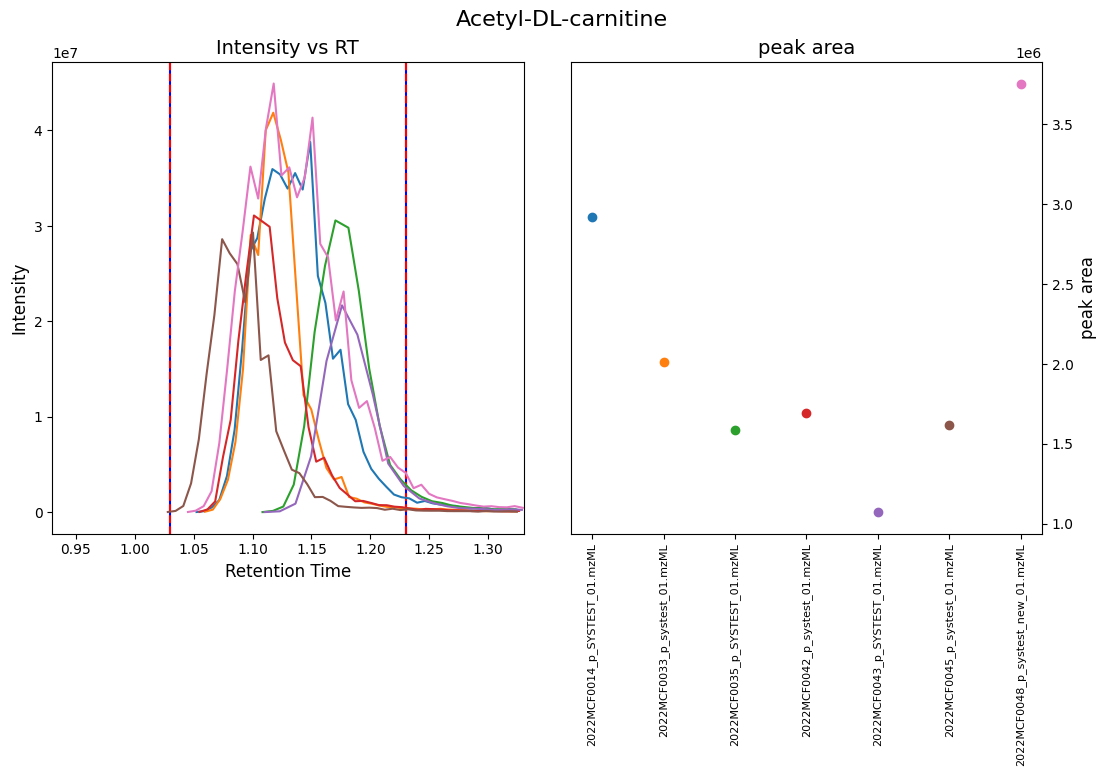

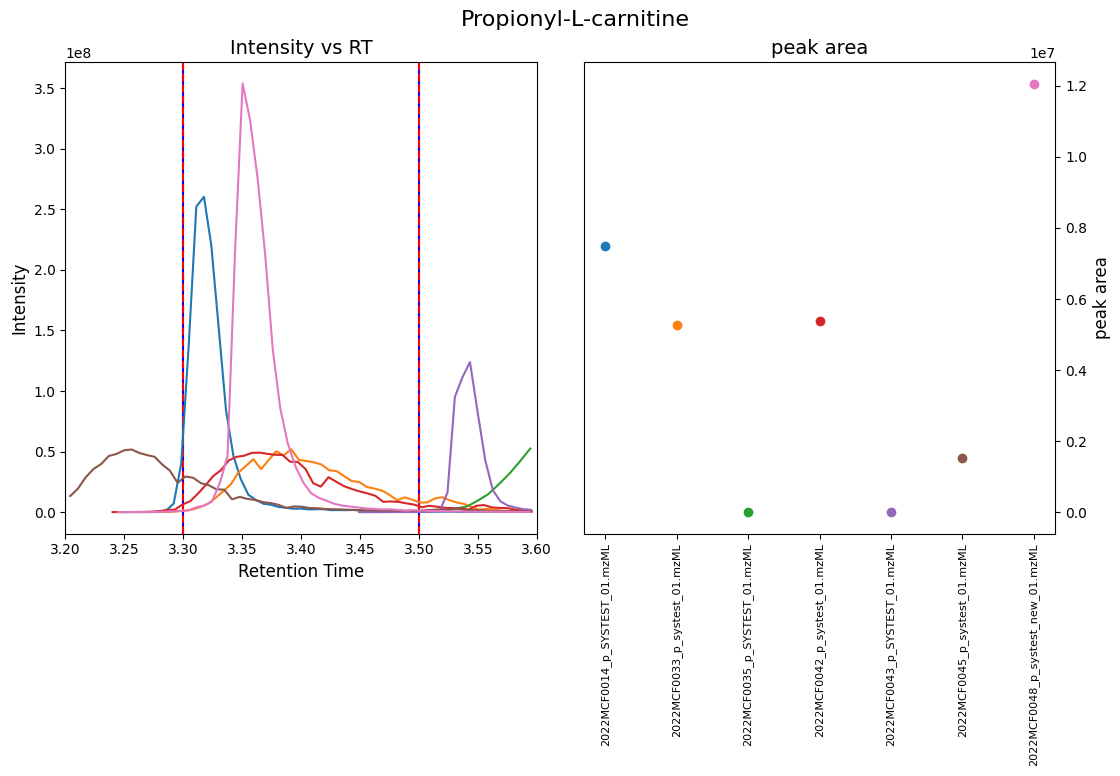

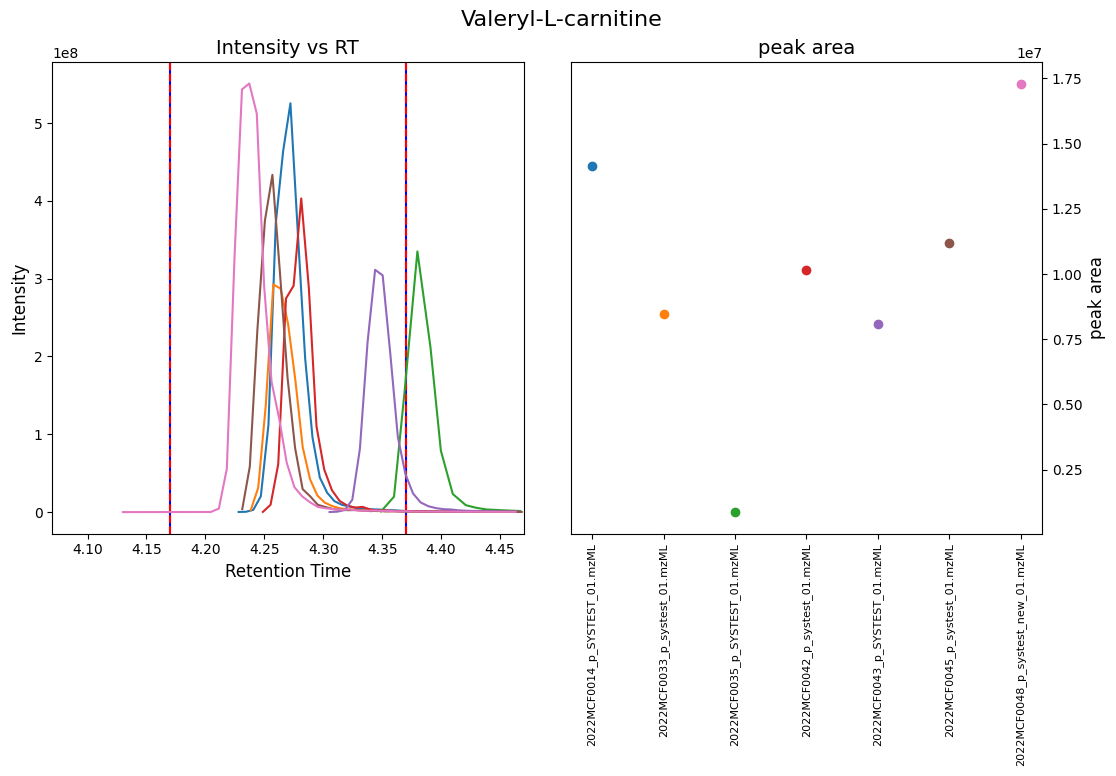

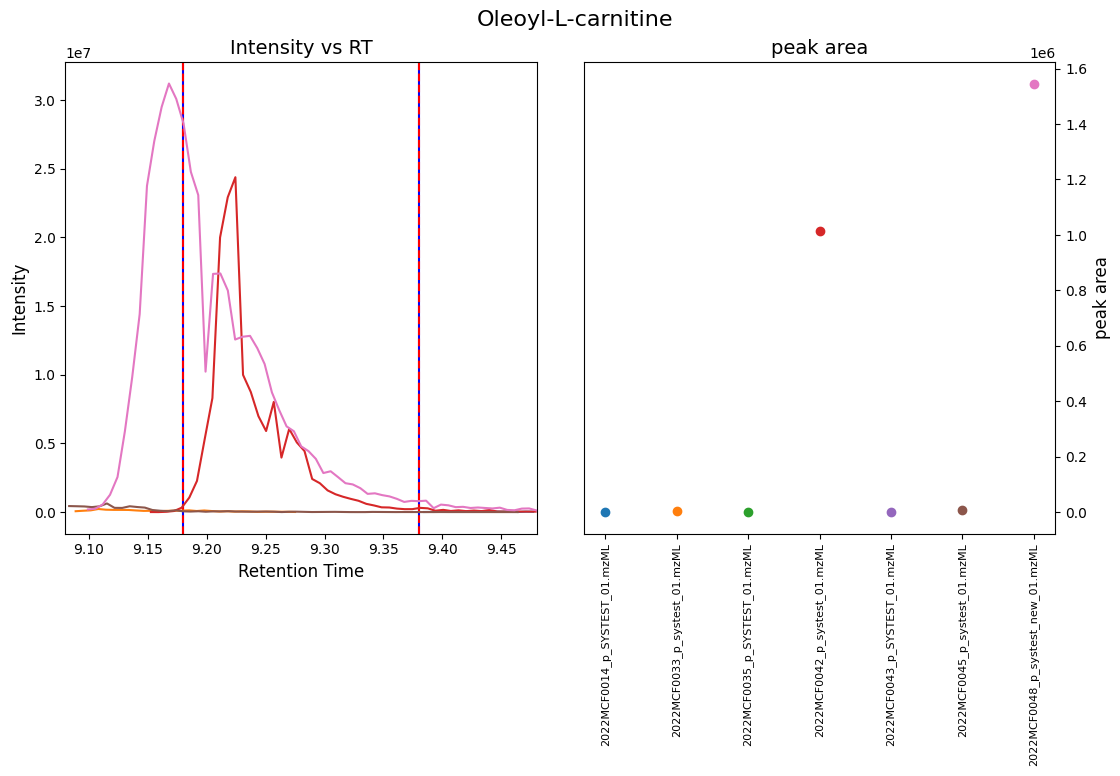

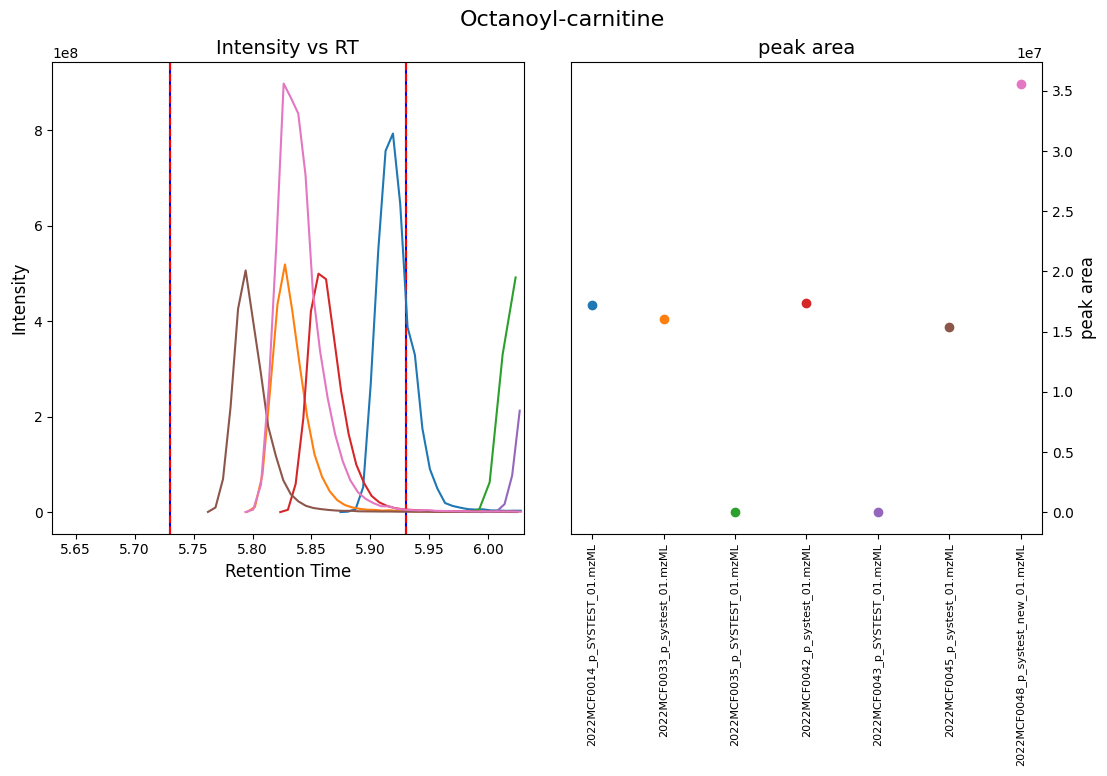

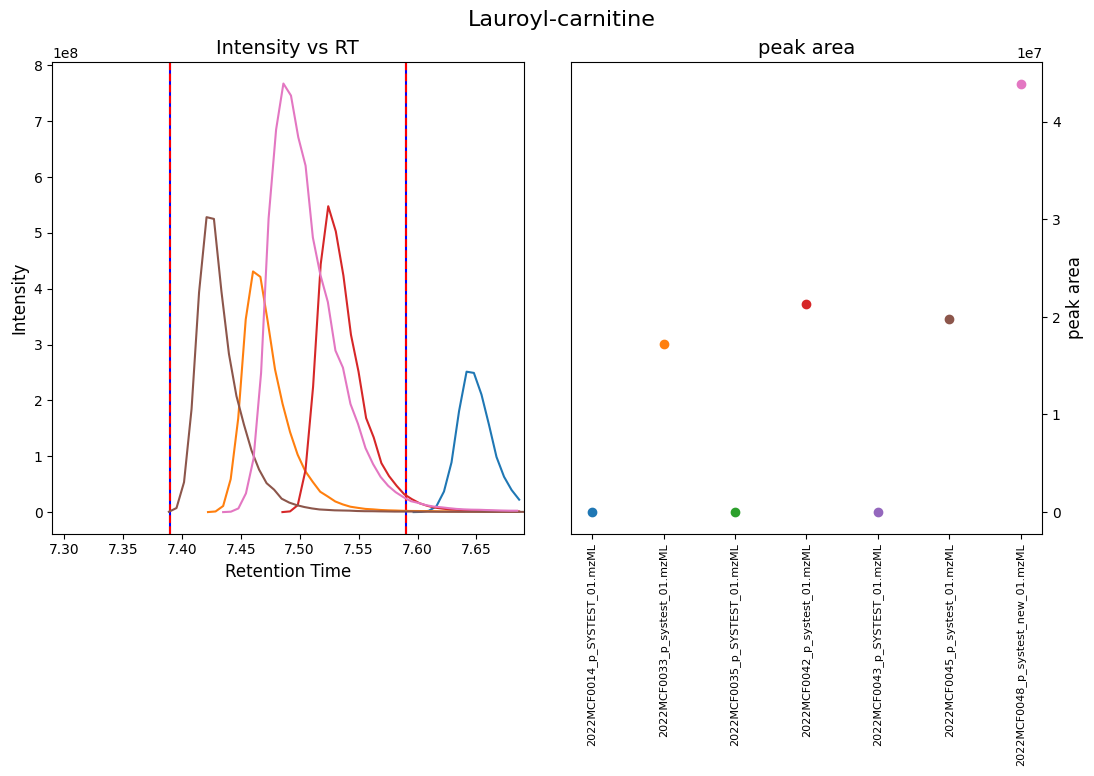

In [8]:
"""Integrate and Plot Results"""
for i, query in enumerate(queries):
    int_range = query['integration_range'][1] - query['integration_range'][0]
    fig1 = plt.figure(figsize=(12,8))
    plt.subplots_adjust(bottom=0.3, top=.9, wspace = .1)
    fig1.suptitle(query['name'], y = .96, fontsize=16)
    fig1_sub1 = fig1.add_subplot(121, title='Intensity vs RT', xlabel='retention time', ylabel='intensity')
    fig1_sub1.title.set_size(14)
    fig1_sub1.axvline(x=query['retention_range'][0], color='b')
    fig1_sub1.axvline(x=query['retention_range'][1], color='b')
    fig1_sub1.axvline(x=query['integration_range'][0], color='r', linestyle='--')
    fig1_sub1.axvline(x=query['integration_range'][1], color='r', linestyle='--')
    fig1_sub1.set_xlim([query['integration_range'][0]-(int_range/2), query['integration_range'][1]+(int_range/2)])
    fig1_sub1.set_ylabel('Intensity', fontsize=12)
    fig1_sub1.set_xlabel('Retention Time', fontsize=12)
    fig1_sub2 = fig1.add_subplot(122, title='peak area')
    # fig1_sub2.set_xlabel('file', fontsize=12)
    fig1_sub2.set_ylabel('peak area', fontsize=12)
    fig1_sub2.title.set_size(14)
    fig1_sub2.tick_params('x', labelrotation=90, labelsize=8)
    fig1_sub2.yaxis.tick_right()
    fig1_sub2.yaxis.set_label_position("right")
    fig1_sub2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    fig1_sub2.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.subplots_adjust(bottom=0.3, top=.9, wspace = .1, left = 0.075)
    for file_n in results_df['file'].unique():
        file_directory, filename = file_n.rsplit('\\', 1)
        filtered_data = results_df.loc[(results_df['query_name']==query['name']) & (results_df['file']==file_n)].copy()
        peak_area = peak_area_df.loc[filename][query['name']]
        fig1_sub1.plot(filtered_data.rt, filtered_data.i)
        fig1_sub2.scatter(filename, peak_area)
    ratio = 1.0
    x_left, x_right = fig1_sub1.get_xlim()
    y_low, y_high = fig1_sub1.get_ylim()
    fig1_sub1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
    x_left, x_right = fig1_sub2.get_xlim()
    y_low, y_high = fig1_sub2.get_ylim()
    fig1_sub2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

"""Save Results to Files"""
timestr = time.strftime("%Y_%m_%d_%H%M")
def save_image(filename):
    p = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs: 
        fig.savefig(p, format='pdf') 
    p.close()  

if not os.path.exists("SpectraSpectre_Output/"+timestr):
    os.makedirs("SpectraSpectre_Output/"+timestr)
pdf_filename = "SpectraSpectre_Output/"+timestr+"/"+timestr+"_images.pdf"  
save_image(pdf_filename) 

peak_area_df_new = peak_area_df.reset_index(names=['CORE_Filename'])

with pd.ExcelWriter("SpectraSpectre_Output/"+timestr+"/"+timestr+"_results.xlsx") as writer:
    peak_area_df_new.to_excel(writer, sheet_name="results", index=False)
    MassQL_query_df.to_excel(writer, sheet_name="queries", index=False)

peak_area_df_biopan = peak_area_df_new.drop(columns=['file_directory'])

def remove_filename_ext(filenameext):
    filenameext = str(filenameext)  # cast to string
    filenamenoext = filenameext[:-5] # remove last five characters
    return str(filenamenoext)

peak_area_df_biopan['CORE_Filename'] =peak_area_df_biopan['CORE_Filename'].apply(remove_filename_ext)

peak_area_df_biopan.set_index('CORE_Filename',inplace=True)
peak_area_df_biopan = peak_area_df_biopan.T
peak_area_df_biopan.to_csv("SpectraSpectre_Output/"+timestr+"/"+timestr+"_results_biopan.csv")  

print("\nResults saved to:")
print(os.getcwd()+"\\SpectraSpectre_Output\n")
print('Complete\n')
# input("Press enter to exit...")